# Image Quality


In [ ]:
!pip install opencv-python>=3.4.2.17
!pip install libsvm>=3.23.0

In [ ]:
import collections
from itertools import chain
import urllib.request as request
import pickle as pickle

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import cv2

from libsvm import svmutil

In [ ]:
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')

In [ ]:
def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))

In [ ]:
def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

In [ ]:
def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

In [ ]:
def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

In [ ]:
def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

In [ ]:
def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))
    
    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    
    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
    
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)
    
    return alpha, mean, sigma_l, sigma_r

In [ ]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    def calculate_features(coefficients_name, coefficients, accum=np.array([])):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var]
        
        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
    
    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)
    
    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
    flatten_features = list(chain.from_iterable(features))
    return np.array(flatten_features)

In [ ]:
def scale_features(features):
    with open('normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model('brisque_svm.txt')
    scaled_brisque_features = scale_features(brisque_features)
    
    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    
    nr_classifier = 1
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)

In [ ]:
%matplotlib inline
def ImageQulaityValue(image):
  gray_image = skimage.color.rgb2gray(image)
  mscn_coefficients = calculate_mscn_coefficients(gray_image, 7, 7/6)
  coefficients = calculate_pair_product_coefficients(mscn_coefficients)
  brisque_features = calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)
  downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
  downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)
  brisque_features = np.concatenate((brisque_features, downscale_brisque_features))
  return calculate_image_quality_score(brisque_features)




# Modified Code

In [ ]:
pip install brisque

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import scipy, scipy.misc, scipy.signal
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import sys,os
import warnings
warnings.filterwarnings("ignore", message="spsolve requires A be CSC or CSR matrix format")
import PIL
from PIL import Image
import PIL.Image
from brisque import BRISQUE

In [ ]:

def computeTextureWeights(fin, sigma, sharpness):
    # Convert the input image to 8-bit unsigned integer format
    fin = cv2.normalize(fin.astype('float64'), None, 0.0, 255.0, cv2.NORM_MINMAX).astype('uint8')

    edges = cv2.Canny(fin, 100, 200)

    abs_edges = np.abs(edges)

    W_h = 1/(abs_edges + 2*sharpness)
    W_v = 1/(abs_edges + 2*sharpness)
    # print(W_h.shape)
    # print(W_v.shape)
    return W_h, W_v
    

In [ ]:
def solveLinearEquation(IN, wx, wy, lamda):
    [r, c] = IN.shape
    k = r * c
    dx =  -lamda * wx.flatten('F')
    dy =  -lamda * wy.flatten('F')
    tempx = np.roll(wx, 1, axis=1)
    tempy = np.roll(wy, 1, axis=0)
    dxa = -lamda *tempx.flatten('F')
    dya = -lamda *tempy.flatten('F')
    tmp = wx[:,-1]
    tempx = np.concatenate((tmp[:,None], np.zeros((r,c-1))), axis=1)
    tmp = wy[-1,:]
    tempy = np.concatenate((tmp[None,:], np.zeros((r-1,c))), axis=0)
    dxd1 = -lamda * tempx.flatten('F')
    dyd1 = -lamda * tempy.flatten('F')
    
    wx[:,-1] = 0
    wy[-1,:] = 0
    dxd2 = -lamda * wx.flatten('F')
    dyd2 = -lamda * wy.flatten('F')
    
    Ax = scipy.sparse.spdiags(np.concatenate((dxd1[:,None], dxd2[:,None]), axis=1).T, np.array([-k+r,-r]), k, k)
    Ay = scipy.sparse.spdiags(np.concatenate((dyd1[None,:], dyd2[None,:]), axis=0), np.array([-r+1,-1]), k, k)
    D = 1 - ( dx + dy + dxa + dya)
    A = ((Ax+Ay) + (Ax+Ay).conj().T + scipy.sparse.spdiags(D, 0, k, k)).T
    
    tin = IN[:,:]
    tout = scipy.sparse.linalg.spsolve(A, tin.flatten('F'))
    # Fortran-style ordering
    OUT = np.reshape(tout, (r, c), order='F')
    
    return OUT

In [ ]:
def tsmooth(img, lamda=0.01, sigma=3.0, sharpness=0.001):
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    x = np.copy(I)
    wx, wy = computeTextureWeights(x, sigma, sharpness)
    S = solveLinearEquation(I, wx, wy, lamda)
    return S

In [ ]:
def rgb2gm(I):
    if (I.shape[2] == 3):
        I = cv2.normalize(I.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        # Arithmetic mean 
        I = (I[:,:,0]+I[:,:,1]+I[:,:,2])/3
        # CHANGE 1

    return I

In [ ]:

def applyK(I, k, a=-0.3293, b=1.1258):
    # power law transformation with gamma correction
    f = lambda x: np.exp((1-x**a)*b)
    # beta = exp((1-k^a)*b)
    beta = f(k)
    # esult is then multiplied by k raised to the power
    #  of a to compensate for the effect of the power law transformation.
    gamma = k**a
    J = (I**gamma)*beta
    return J



In [ ]:
# def applyK(I, k, a=1.0, b=1.0):
#     # logarithmic transformation with gamma correction
#     f = lambda x: b*np.log(a*(1 + x))
#     # beta = b*log(a*(1 + k))
#     beta = f(k)
#     # result is then multiplied by k raised to the power
#     # of a to compensate for the effect of the logarithmic transformation.
#     gamma = k**a
#     J = (I**gamma)*beta
#     # normalize output to range [0, 255]
#     result = cv2.normalize(J, None, 0, 255, cv2.NORM_MINMAX)
#     result = result.astype(np.uint8)
#     return result


In [ ]:


# def applyK(I, k, clipLimit=2.0, tileGridSize=(8,8)):
#     # # Convert image to grayscale
#     # img = cv2.imread('/content/sample_data/testImage1.jpg')
#     # # I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
#     gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

#     # Create CLAHE object
#     clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)

#     # Apply CLAHE to the grayscale image
#     gray_clahe = clahe.apply(gray)

#     # Apply power law transformation with gamma correction
#     gamma = k**(-0.3293)
#     beta = np.exp((1 - k**(-0.3293)) * 1.1258)
#     J = (gray_clahe**gamma) * beta

#     # Convert back to BGR color space
#     J = cv2.cvtColor(J.astype(np.float32), cv2.COLOR_GRAY2BGR)

#     return J

In [ ]:
# # HISTOGRAM EQUILISATION TRANSFORMATION -Brisque Score: 47.254407140503844
# def applyK(I, k, a=-0.3293, b=1.1258):
#     # Normalize the input image
#     I_norm = cv2.normalize(I.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    
#     # Calculate the histogram of the normalized image
#     hist, bins = np.histogram(I_norm.flatten(), 256, [0,1])
    
#     # Calculate the cumulative distribution function (CDF)
#     cdf = hist.cumsum()
#     cdf = (cdf / cdf[-1]).astype('float64')
    
#     # Apply the power law transformation
#     f = lambda x: np.exp((1-x**a)*b)
#     beta = f(k)
#     gamma = k**a
#     J_norm = (I_norm**gamma)*beta
    
#     # Calculate the histogram of the transformed image
#     hist, bins = np.histogram(J_norm.flatten(), 256, [0,1])
    
#     # Calculate the cumulative distribution function (CDF)
#     cdf_J = hist.cumsum()
#     cdf_J = (cdf_J / cdf_J[-1]).astype('float64')
    
#     # Create the lookup table
#     lut = (cdf_J * 255).astype('uint8')
    
#     # Apply the lookup table to the transformed image
#     J_eq = cv2.LUT((J_norm*255).astype('uint8'), lut)
    
#     # Normalize the output image
#     J = cv2.normalize(J_eq.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    
#     return J


In [ ]:

def entropy(X):
    tmp = X * 255
    tmp[tmp > 255] = 255
    tmp[tmp<0] = 0
    tmp = tmp.astype(np.uint8)
    #  The histogram of the image is calculated and the probability of each pixel value is calculated
    _, counts = np.unique(tmp, return_counts=True)
    pk = np.asarray(counts)
    # entropy of the image is calculated as the negative 
    # sum of the product of each probability and its logarithm, using base 2.
    pk = 1.0*pk / np.sum(pk, axis=0)
    S = -np.sum(pk * np.log2(pk), axis=0)
    return S

In [ ]:
def maxEntropyEnhance(I,isBad, a=-0.3293, b=1.1258):
    # Esatimate k
    tmp = cv2.resize(I, (50,50), interpolation=cv2.INTER_AREA)
    tmp[tmp<0] = 0
    tmp = tmp.real
    Y = rgb2gm(tmp)
    
    isBad = isBad * 1
  
    # MAKE A TUPLE OF (50,50)
    size = (50,50)
    
    # image_pil=Image.fromarray(isBad)
    image_pil = Image.fromarray(np.uint8(isBad))
    if size:
        bic=Image.BICUBIC
        image_pil=image_pil.resize(size, bic)
        isBad=np.array(image_pil)
   
    isBad[isBad < 0.5] = 0
    isBad[isBad >= 0.5] = 1


    # # IndexError: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 301
    # resize isBad to 50,50

    Y = Y[isBad==1]
    
    if Y.size == 0:
       J = I
       return J
    
    f = lambda k: -entropy(applyK(Y, k))
    opt_k = scipy.optimize.fminbound(f, 1, 7)
    # print("optimal K value:",opt_k)
    # Apply k
    J = applyK(I, opt_k) - 0.01
    # J = applyK(I, opt_k, a, b) - 0.01
    return J

In [ ]:
def fusion(img, mu=0.5, a=-0.3293, b=1.1258):
    lamda = 0.5
    sigma = 5
    # input image
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)

    # Weight matrix estimation
    t_b = np.max(I, axis=2)
    # resized_image=scipy.misc.imresize(t_b, 0.5, interp='bicubic', mode='F')
    img2 = np.array(Image.fromarray(t_b).resize(
    (int(0.5 * t_b.shape[0]), int(t_b.shape[1] * 0.5)),
    resample=PIL.Image.BICUBIC)
)

    t_our = cv2.resize(tsmooth(img2, lamda, sigma), (t_b.shape[1], t_b.shape[0]), interpolation=cv2.INTER_AREA)
   
  
    # Apply camera model with k(exposure ratio)
    isBad = t_our < 0.5
    
    J = maxEntropyEnhance(I, isBad)

    # W: Weight Matrix
    t = np.zeros((t_our.shape[0], t_our.shape[1], I.shape[2]))
    for i in range(I.shape[2]):
        t[:,:,i] = t_our
    W = t**mu

    I2 = I*W
    J2 = J*(1-W)

    result = I2 + J2
    result = result * 255
    result[result > 255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

PSNR: 15.43 dB
SSIM: 0.34
Brisque Score: 33.811946306275075


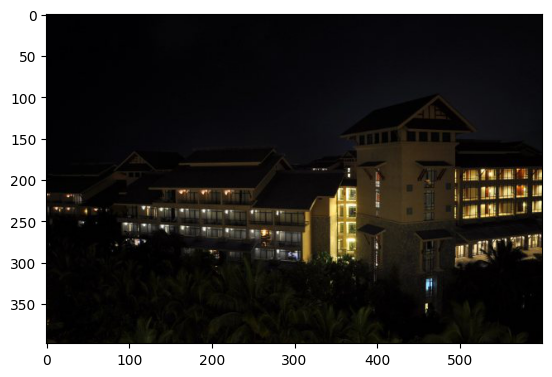

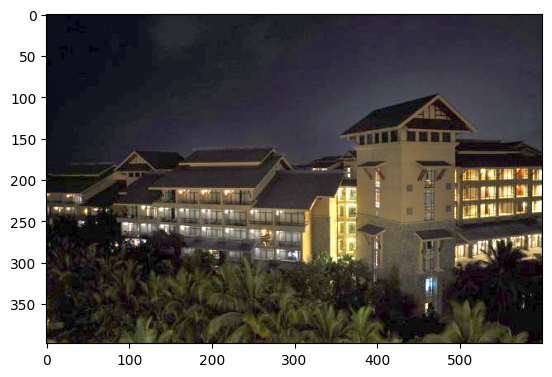

In [ ]:
img_name = '/content/sample_data/testImage1.jpg'
img = imageio.v2.imread(img_name)
result = fusion(img)
psnr_value = psnr(img, result, data_range=255)

# calculate SSIM
ssim_value = ssim(img, result, channel_axis=-1, data_range=255)

# print results
print("PSNR: {:.2f} dB".format(psnr_value))
print("SSIM: {:.2f}".format(ssim_value))
# print(result.shape)
imageio.v3.imwrite('/content/sample_data/EnhancedImage.png', result)
obj = BRISQUE(url=False)
result_img = cv2.imread('/content/sample_data/EnhancedImage.png', cv2.IMREAD_COLOR).astype(np.uint8)
print("Brisque Score:",obj.score(result_img))
plt.imshow(img)
plt.show()
plt.imshow(result)
plt.show()